<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/video_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00


In [2]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
filepath = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' # @param {type: "string"}
!ls -l $filepath

Mounted at /content/drive
-r-------- 1 root root 1425830568 Nov 16  2017 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi


In [3]:
video = media.read_video(filepath)

In [4]:
# Compress the video with default settings (H.264 codec)
COMPRESSION_BIT_RATES = {500_000, 200_000, 100_000}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))

3234958
1297732
651944


In [5]:
# Save the compressed video to a file
with open('/tmp/subject1_500_000.mp4', 'wb') as f:
    f.write(compressed_data[500_000])
with open('/tmp/subject1_200_000.mp4', 'wb') as f:
    f.write(compressed_data[200_000])
with open('/tmp/subject1_100_000.mp4', 'wb') as f:
    f.write(compressed_data[100_000])

In [6]:
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_500_000.mp4')
compressed_video_2 = media.read_video('/tmp/subject1_200_000.mp4')
compressed_video_3 = media.read_video('/tmp/subject1_100_000.mp4')
videos = {'Original': video[:10], 'Compressed_200_000': compressed_video_2[:10], 'Compressed_100_000': compressed_video_3[:10], 'Compressed_500_000': compressed_video[:10] }
media.show_videos(videos, fps=30)

1547


""

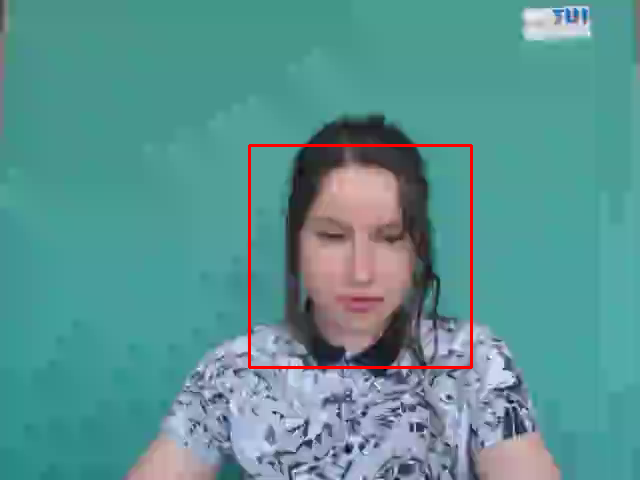

In [112]:
## Preprocessing - face detection and cropping
import cv2
import datetime
import math
from cv2 import dnn_superres

def read_video(video_file):
    """Reads a video file, returns frames(T, H, W, 3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
      frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      frame = np.asarray(frame)
      frames.append(frame)
      success, frame = VidObj.read()
    return np.asarray(frames)

def face_detection(frame, use_larger_box=False, larger_box_coef=1.0):
  """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bounding box.
  """
  # Use OpenCV's Haar Cascade algorithm implementation for face detection
  # This should only utilize the CPU
  detector = cv2.CascadeClassifier('/content/drive/MyDrive/research_project/DATASETS/haarcascade_frontalface_default.xml')

  # Computed face_zone(s) are in the form [x_coord, y_coord, width, height]
  # (x,y) corresponds to the top-left corner of the zone to define using
  # the computed width and height.
  face_zone = detector.detectMultiScale(frame)

  if len(face_zone) < 1:
    print("ERROR: No Face Detected")
    face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
  elif len(face_zone) >= 2:
    # Find the index of the largest face zone
    # The face zones are boxes, so the width and height are the same
    max_width_index = np.argmax(face_zone[:, 2])  # Index of maximum width
    face_box_coor = face_zone[max_width_index]
    print("Warning: More than one faces are detected. Only cropping the biggest one.")
  else:
    face_box_coor = face_zone[0]
  if use_larger_box:
    face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
    face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
    face_box_coor[2] = larger_box_coef * face_box_coor[2]
    face_box_coor[3] = larger_box_coef * face_box_coor[3]
  return face_box_coor

def superres(frame, model_path, model_name, scale):
  """Super resolution using DNN.

     Args:
       frames(np.array): Video frames.
       model_path(str): Path to the pre-trained model.
       model_name(str): Name of the model.
       scale(int): Scale factor.
     Returns:
        upscaled_frames(list[np.array(float)]): Upscaled frames
  """
  # Create a Super Resolution object
  sr = dnn_superres.DnnSuperResImpl_create()

  # Read the pre-trained model
  sr.readModel(model_path)

  # Set the model and scale
  sr.setModel(model_name, scale)

  # Upscale the image
  upscaled_frame = sr.upsample(frame)
  return upscaled_frame

def crop_face_resize(frames, use_face_detection,  use_larger_box, larger_box_coef, use_dynamic_detection,
                         detection_freq, use_median_box, width, height,
                     res_model_path, model_name, scale, denoise=False, upscale=False):
  """Crop face and resize frames.

     Args:
       frames(np.array): Video frames.
       use_face_detection(bool):  Whether crop the face.
       use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
       detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
       width(int): Target width for resizing.
       height(int): Target height for resizing.
       use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
       larger_box_coef(float): the coefficient of the larger region(height and weight)
                             the middle point of the detected region will stay still during the process of enlarging.
     Returns:
        resized_frames(list[np.array(float)]): Resized and cropped frames
  """
  # Face Cropping
  if use_dynamic_detection:
    num_dynamic_det = math.ceil(frames.shape[0] / detection_freq)
  else:
    num_dynamic_det = 1
  face_region_all = []
  # Perform face detection by num_dynamic_det" times.
  for idx in range(num_dynamic_det):
    if use_face_detection:
       face_region_all.append(face_detection(frames[detection_freq * idx], use_larger_box, larger_box_coef))
    else:
       face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
  if use_median_box:
     # Generate a median bounding box based on all detected face regions
     face_region_median = np.median(np.asarray(face_region_all, dtype='int'), axis=0).astype('int')
  print(np.asarray(face_region_all, dtype='int'))

  # Frame Resizing
  #resized_frames = np.zeros((frames.shape[0], height, width, 3))
  resized_frames = []
  for i in range(0, frames.shape[0]):
    frame = frames[i]
    restrored_frame = frames[i]
    if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
      reference_index = i // detection_freq
    else:  # use the first region obtrained from the first frame.
      reference_index = 0
    if use_face_detection:
      if use_median_box:
         face_region = face_region_median
      else:
         face_region = np.asarray(face_region_all, dtype='int')[reference_index]
      frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
         max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]
      # To remove compression noise from an image using OpenCV, the most
      # effective method is to utilize the "fastNlMeansDenoising" function,
      # which implements the Non-Local Means (NLM) denoising algorithm;
      # this is particularly well-suited for handling compression artifacts
      # due to its ability to consider similar pixel neighborhoods across the
      # image to reduce noise while preserving edges and details.
      # Other methods (less effective for compression noise):
      #    Median filtering: Can be used for basic smoothing but might blur edges.
      #    Gaussian blur: May help with some noise but can also blur details.
      #    Bilateral filtering: Preserves edges better than Gaussian blur but might not be as effective for compression noise.
      if denoise:
        #restored_frame = cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21)
        #restored_frame = cv2.fastNlMeansDenoisingColored(frame,None,5,5,7,21)
        restored_frame = cv2.bilateralFilter(frame, 9, 75, 75)
      if upscale:
        # Apply super resolution
        restored_frame = superres(frame, res_model_path, model_name, scale)
        print(datetime.datetime.now().strftime("%H:%M:%S"))
        print("processed frame: " + str(i))

    # Resize the frame
    if denoise:
      resized_frame = cv2.resize(restored_frame, (width, height), interpolation=cv2.INTER_AREA)
      resized_frames.append(resized_frame)
    elif upscale:
      resized_frame = cv2.resize(restored_frame, (width, height), interpolation=cv2.INTER_AREA)
      resized_frames.append(resized_frame)
    else:
      resized_frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
      resized_frames.append(resized_frame)
    #print("Image after cropping and resizing:")
    #media.show_image(resized_frame1)
    #resized_frame2 = cv2.resize(upscaled_frame, (width, height), interpolation=cv2.INTER_AREA)
    #print("Image after upscaling:")
    #media.show_image(resized_frame2)
    #resized_frames[i] = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
  #return resized_frames
  return np.array(resized_frames)

video_file = '/tmp/subject1_100_000.mp4' # @param{type: "string"}
cropped_and_resized_file = '/tmp/subject1_100_000_cropped_and_resized.mp4' # @param{type: "string"}
frames = read_video(video_file)
print(len(frames))
media.show_video(frames[:10], fps=30)
face_box_coor = face_detection(frames[0], use_larger_box=True, larger_box_coef=1.5)
new_frame = cv2.rectangle(frames[0], (face_box_coor[0], face_box_coor[1]), (face_box_coor[0] + face_box_coor[2], face_box_coor[1] + face_box_coor[3]), (255, 0, 0), 2)
media.show_image(new_frame)

[[249 145 222 222]]


Original,Gaussian blur,Bilateral,Denoised,Sharpened

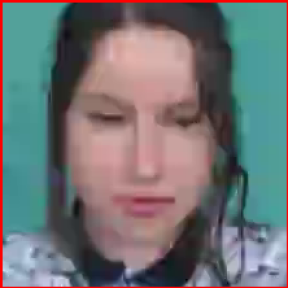
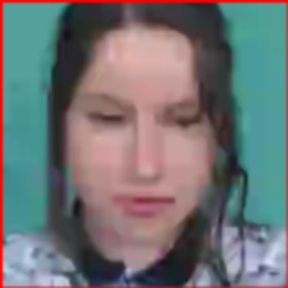
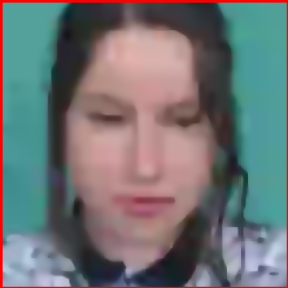
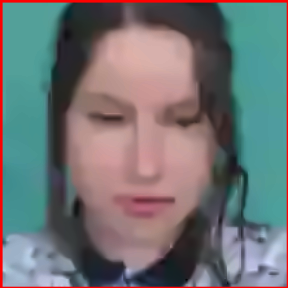
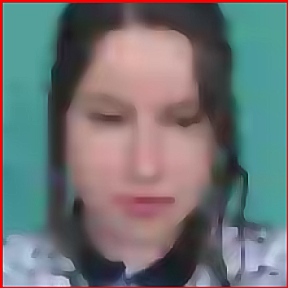

In [113]:
# Specify the path to the pre-trained model
MODEL_PATH = "/content/drive/MyDrive/research_project/vsr_model/EDSR_x4.pb"  # @param {type:"string"}
MODEL_NAME = "edsr" # @param {type: "string"}
SCALE = 4 # @param {type: "integer"}
HEIGHT = 288 # @param {type: "integer"}
WIDTH = 288 # @param {type: "integer"}
NUM_FRAMES = 150 # @param {type: "integer"}
resized_frames1 = crop_face_resize(frames[:1], use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=False, upscale=False)

import cv2

for frame in resized_frames1:
  #  Reduce blockiness
  # Apply Gaussian Blur
  blurred = cv2.GaussianBlur(frame, (5, 5), 0)
  #blurred = cv2.GaussianBlur(frame, (7, 7), 2)
  #media.show_image(blurred)
  # Apply Bilateral Filter (preserves edges)
  bilateral = cv2.bilateralFilter(frame, 9, 75, 75)
  #bilateral = cv2.bilateralFilter(frame, 9, 18, 18)
  # Reduce noisy edges
  #denoised = cv2.fastNlMeansDenoisingColored(frame, None, 5, 5, 7, 21)
  denoised = cv2.fastNlMeansDenoisingColored(frame, None, 5, 5, 7, 21)
  # Sharpen
  sharpened = cv2.addWeighted(bilateral, 2.5, blurred, -1.5, 0)

  images = {'Original': frame, 'Gaussian blur': blurred, 'Bilateral': bilateral, 'Denoised': denoised, 'Sharpened': sharpened}
  media.show_images(images)





In [114]:
resized_frames2 = crop_face_resize(frames[:NUM_FRAMES], use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=True, upscale=False)
resized_frames3 = crop_face_resize(frames[:20], use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=False, upscale=True)

#videos = {'Original resized': resized_frames1, 'Denoised': resized_frames2}
videos = {'Original resized': resized_frames1[:20], 'Denoised': resized_frames2[:20], 'Upscaled': resized_frames3}
media.show_videos(videos, fps=30)

[[249 145 222 222]]
[[249 145 222 222]]
18:06:53
processed frame: 0
18:07:01
processed frame: 1
18:07:08
processed frame: 2
18:07:16
processed frame: 3
18:07:24
processed frame: 4
18:07:32
processed frame: 5
18:07:40
processed frame: 6
18:07:47
processed frame: 7
18:07:55
processed frame: 8
18:08:03
processed frame: 9
18:08:11
processed frame: 10
18:08:18
processed frame: 11
18:08:26
processed frame: 12
18:08:34
processed frame: 13
18:08:42
processed frame: 14
18:08:50
processed frame: 15
18:08:57
processed frame: 16
18:09:05
processed frame: 17
18:09:13
processed frame: 18
18:09:20
processed frame: 19


In [121]:
import cv2
import numpy as np

def enhance_red(frame, factor=1.5):
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)

    red_mask = np.logical_or(h < 10, h > 170)
    s[red_mask] = np.clip(s[red_mask] * factor, 0, 255)

    hsv_enhanced = cv2.merge([h, s, v])
    #enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)
    #return enhanced_image
    return hsv_enhanced

FACTOR = 1.5 # @param {type: "number"}
enhanced_frames1 = []
enhanced_frames2 = []
enhanced_frames3 = []
for frame in resized_frames1:
  enhanced_frame = enhance_red(frame, factor=FACTOR)
  enhanced_frames1.append(enhanced_frame)
for frame in resized_frames2:
  enhanced_frame = enhance_red(frame, factor=FACTOR)
  enhanced_frames2.append(enhanced_frame)
for frame in resized_frames3[:20]:
  enhanced_frame = enhance_red(frame, factor=FACTOR)
  enhanced_frames3.append(enhanced_frame)

media.show_videos({'Original': enhanced_frames1, 'Denoised': enhanced_frames2, 'Upscaled': enhanced_frames3}, fps=30)


In [26]:
import os

def frames_to_video(frames, output_path, fps=30):
    """Converts a sequence of frames to an MPEG4 video.

    Args:
        frames: A list of frames (numpy arrays) to be converted to a video.
        output_path: Name of the output video file (e.g., 'output.mp4').
        fps: Frames per second for the output video.
    """

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MPEG-4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_writer.write(frame_rgb)

    video_writer.release()

OUTPUT_PATH = '/content/drive/MyDrive/research_project/data/preprocessed' # @param{type: "string"}
FILE_NAME = 'subject1_100_000_cropped_and_resized.mp4' # @param{type: "string"}
if not os.path.exists(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)

frames_to_video(frames=resized_frames, output_path=os.path.join(OUTPUT_PATH, FILE_NAME), fps=30)

In [27]:
video2 = media.read_video(os.path.join(OUTPUT_PATH, FILE_NAME))
media.show_video(video2, fps=30)

In [10]:
import cv2
import os
import shutil

"""
This script converts a video into individual frames and saves them to a specified directory.
Only a subset of frames is saved based on a defined interval to match the desired frame rate for further processing.
"""

# Path to the video file
video_path = '/tmp/subject1_200_000.mp4' # @param {type: "string"}

# Directory to save the frames
output_folder = '/tmp/output_dir_200' # @param {type: "string"}

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Load the video
cap = cv2.VideoCapture(video_path)

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frames_per_second = 10
interval = int(fps / frames_per_second)

frame_count = 0
saved_frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Save frame if it's in the interval
    if frame_count % interval == 0:
        frame_filename = os.path.join(output_folder, f'frame_{saved_frame_count:04d}.png')
        cv2.imwrite(frame_filename, frame)
        saved_frame_count += 1

    frame_count += 1

cap.release()
print(f'Extracted {saved_frame_count} frames to {output_folder}')

Extracted 516 frames to /tmp/output_dir_200


In [11]:
!ls -l $output_folder

total 134664
-rw-r--r-- 1 root root 232830 Feb 28 17:57 frame_0000.png
-rw-r--r-- 1 root root 233011 Feb 28 17:57 frame_0001.png
-rw-r--r-- 1 root root 233313 Feb 28 17:57 frame_0002.png
-rw-r--r-- 1 root root 233334 Feb 28 17:57 frame_0003.png
-rw-r--r-- 1 root root 233404 Feb 28 17:57 frame_0004.png
-rw-r--r-- 1 root root 246544 Feb 28 17:57 frame_0005.png
-rw-r--r-- 1 root root 249927 Feb 28 17:57 frame_0006.png
-rw-r--r-- 1 root root 255300 Feb 28 17:57 frame_0007.png
-rw-r--r-- 1 root root 254169 Feb 28 17:57 frame_0008.png
-rw-r--r-- 1 root root 261888 Feb 28 17:57 frame_0009.png
-rw-r--r-- 1 root root 264036 Feb 28 17:57 frame_0010.png
-rw-r--r-- 1 root root 264711 Feb 28 17:57 frame_0011.png
-rw-r--r-- 1 root root 264919 Feb 28 17:57 frame_0012.png
-rw-r--r-- 1 root root 265898 Feb 28 17:57 frame_0013.png
-rw-r--r-- 1 root root 266520 Feb 28 17:57 frame_0014.png
-rw-r--r-- 1 root root 267529 Feb 28 17:57 frame_0015.png
-rw-r--r-- 1 root root 267511 Feb 28 17:57 frame_0016.png
-

In [ ]:
# Clone the MdVRNet (video restoration model) repository from github if not already setup
import os

dir_path = '/content/MdVRNet'
if os.path.isdir(dir_path):
  print(f"The directory '{dir_path}' exists.")
else:
  !git clone https://github.com/trappertwo/MdVRNet.git
%cd '{dir_path}'
!ls '{dir_path}'

Cloning into 'MdVRNet'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 130 (delta 13), reused 0 (delta 0), pack-reused 107 (from 1)
Receiving objects: 100% (130/130), 12.35 MiB | 15.08 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/MdVRNet
dataloaders.py		  images	     README.md	       train_common.py
dataset.py		  mdvrnet.py	     requirements.txt  train_dpen.py
estimate_params.py	  models.py	     test_dpen.py      train_mdvrnet.py
generate_png_from_mp4.py  pretrained_models  test_mdvrnet.py   utils.py


In [ ]:
# Explicitly install PyQt5 to use interactive plotting and avoid non-interactive backends
# See this relevant issue for more details: https://github.com/astral-sh/uv/issues/6893
# This requires Python 3.9+
!which python
!python --version
!pip install  --no-build-isolation PyQt5

/usr/local/bin/python
Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 25.9 MB/s eta 0:00:00


In [ ]:
### Setup using uv
### This gives an error when building the mamba package.
### Hence we need to directly install causal-conv1d and mamba-ssm.
### See README file under tools/mamba.
#!bash setup.sh uv
%%bash
rm -rf .venv
uv venv --python 3.8
source .venv/bin/activate
uv pip install --no-build-isolation setuptools wheel
uv pip install --no-build-isolation torch==2.1.2+cu121 torchvision==0.16.2+cu121 --index-url https://download.pytorch.org/whl/cu121
uv pip install --no-build-isolation scikit-Image
uv pip install --no-build-isolation pytest
uv pip install --no-build-isolation pycodestyle
uv pip install --no-build-isolation opencv-python
uv pip install --no-build-isolation future
uv pip install --no-build-isolation tensorboardx



Using CPython 3.8.20
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.11.11 environment at: /usr
Audited 2 packages in 242ms
Using Python 3.11.11 environment at: /usr
Resolved 18 packages in 2.52s
 Downloaded torchvision
 Downloaded triton
 Downloaded torch
Prepared 3 packages in 37.26s
Uninstalled 3 packages in 653ms
Installed 3 packages in 194ms
 - torch==2.5.1+cu124 (from https://download.pytorch.org/whl/cu124/torch-2.5.1%2Bcu124-cp311-cp311-linux_x86_64.whl)
 + torch==2.1.2+cu121
 - torchvision==0.20.1+cu124 (from https://download.pytorch.org/whl/cu124/torchvision-0.20.1%2Bcu124-cp311-cp311-linux_x86_64.whl)
 + torchvision==0.16.2+cu121
 - triton==3.1.0
 + triton==2.1.0
Using Python 3.11.11 environment at: /usr
Audited 1 package in 255ms
Using Python 3.11.11 environment at: /usr
Audited 1 package in 307ms
Using Python 3.11.11 environment at: /usr
Resolved 1 package in 27ms
Prepared 1 package in 4ms
Installed 1 package in 3ms
 + pycodest

In [ ]:
### List packages in the virtual environment
!source .venv/bin/activate
!uv pip list

Using Python 3.11.11 environment at: /usr
Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.12
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array-record                       0.6.0
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.2.17.0.34.13
astunparse                         1.6.3
atpublic                           4.1.0
attrs              